In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("F1 Data").config('spark.ui.port', '4050').getOrCreate()

### __XỬ LÝ CHÍNH__

#####__XỬ LÝ DỮ LIỆU__

In [ ]:
from pyspark.sql.types import *

schema_laps = StructType([
    StructField("Time", LongType(), True),
    StructField("Driver", StringType(), True),
    StructField("DriverNumber", StringType(), True),
    StructField("LapTime", LongType(), True),
    StructField("LapNumber", DoubleType(), True),
    StructField("Stint", DoubleType(), True),
    StructField("PitOutTime", LongType(), True),
    StructField("PitInTime", LongType(), True),
    StructField("Sector1Time", LongType(), True),
    StructField("Sector2Time", LongType(), True),
    StructField("Sector3Time", LongType(), True),
    StructField("Sector1SessionTime", LongType(), True),
    StructField("Sector2SessionTime", LongType(), True),
    StructField("Sector3SessionTime", LongType(), True),
    StructField("SpeedI1", DoubleType(), True),
    StructField("SpeedI2", DoubleType(), True),
    StructField("SpeedFL", DoubleType(), True),
    StructField("SpeedST", DoubleType(), True),
    StructField("IsPersonalBest", BooleanType(), True),
    StructField("Compound", StringType(), True),
    StructField("TyreLife", DoubleType(), True),
    StructField("FreshTyre", BooleanType(), True),
    StructField("Team", StringType(), True),
    StructField("LapStartTime", LongType(), True),
    StructField("LapStartDate", StringType(), True),
    StructField("TrackStatus", StringType(), True),
    StructField("Position", DoubleType(), True),
    StructField("Deleted", BooleanType(), True),
    StructField("DeletedReason", StringType(), True),
    StructField("FastF1Generated", BooleanType(), True),
    StructField("IsAccurate", BooleanType(), True),
])

schema_weather = StructType([
    StructField("Time", LongType(), True),
    StructField("AirTemp", DoubleType(), True),
    StructField("Humidity", DoubleType(), True),
    StructField("Pressure", DoubleType(), True),
    StructField("Rainfall", BooleanType(), True),
    StructField("TrackTemp", DoubleType(), True),
    StructField("WindDirection", LongType(), True),
    StructField("WindSpeed", DoubleType(), True),
])

In [ ]:
# Thay lốp cũ => không bắt đầu từ 1 => chưa đúng
# Tính thời gian trong stint bằng cách group by theo DriverNumber, Stint lấy sum PitOutTime - sum PitInTime

def count_tyre_life_1(df):
    # Lọc ra các dòng có TyreLife = 1
    df_tyre_1 = df.filter(F.col("TyreLife") == 1)

    # Đếm số dòng có TyreLife = 1 cho mỗi tay đua
    tyre_change_count_df = df_tyre_1.groupBy("DriverNumber").agg(F.count("*").alias("TyreChangeCount"))

    return tyre_change_count_df

# Hàm tính trung bình thời gian trong stint cho mỗi tay đua
def calculate_avg_stint_time(df):
    # Nhóm theo DriverNumber và Stint, sau đó tính tổng PitOutTime và PitInTime
    stint_time_df = df.groupBy("DriverNumber", "Stint").agg(
        F.sum("PitOutTime").alias("TotalPitOutTime"),
        F.sum("PitInTime").alias("TotalPitInTime")
    )

    # Tính hiệu PitOutTime - PitInTime cho mỗi DriverNumber và Stint
    stint_time_df = stint_time_df.withColumn("StintTime", F.col("TotalPitOutTime") - F.col("TotalPitInTime"))

    # Tính trung bình thời gian trong stint cho mỗi DriverNumber
    avg_stint_time_df = stint_time_df.groupBy("DriverNumber").agg(
        F.avg("StintTime").alias("AvgStintTime")
    )

    return avg_stint_time_df

In [ ]:
import os
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import expr, col, row_number

In [ ]:
def preprocess_fastf1_data(base_folder_path, years, spark,
                            schema_laps, schema_weather,
                            count_tyre_life_1, driver_stats):
    final_dataframes = []

    def mode_spark(df, group_key, target_col):
        return df.groupBy(group_key).agg(
            expr(f"first({target_col}) as {target_col}_mode")
        )

    for year in years:
        folder_path = os.path.join(base_folder_path, year)
        if not os.path.exists(folder_path):
            continue

        for filename in os.listdir(folder_path):
            if "laps" in filename and "_r_" in filename and filename.endswith('.parquet'):

                # Load các file cần thiết
                spark_laps = spark.read.schema(schema_laps).parquet(os.path.join(folder_path, filename))
                spark_weather = spark.read.schema(schema_weather).parquet(os.path.join(folder_path, filename.replace("laps", "weather")))
                df_drivers = pd.read_parquet(os.path.join(folder_path, filename.replace("laps", "drivers")))
                df_results = pd.read_parquet(os.path.join(folder_path, filename.replace("laps", "results")))

                # Tính số lần thay lốp
                tyre_change_count_df = count_tyre_life_1(spark_laps).toPandas()
                df_results = df_results.merge(tyre_change_count_df, on="DriverNumber", how="left")

                # Join laps với weather theo thời gian gần nhất liền trước
                weather_sorted = spark_weather.orderBy("Time")
                spark_joined = spark_laps.alias("laps").join(
                    weather_sorted.alias("weather"),
                    on=expr("laps.Time >= weather.Time"),
                    how="left"
                ).withColumn("weather_time_diff", col("laps.Time") - col("weather.Time"))

                window_spec_weather = Window.partitionBy("laps.LapNumber", "laps.DriverNumber", "laps.Time") \
                                            .orderBy(col("weather_time_diff").asc_nulls_last())

                joined_final = spark_joined.withColumn("row_number", row_number().over(window_spec_weather)) \
                                           .filter(col("row_number") == 1) \
                                           .drop("row_number", "weather_time_diff")

                # Tổng hợp các đặc trưng
                agg_df = joined_final.groupBy("DriverNumber").agg(
                    F.avg("LapTime").alias("LapTime_mean"),
                    F.countDistinct("Stint").alias("Stint_nunique"),
                    F.countDistinct("WindDirection").alias("WindDirection_nunique"),
                    F.avg("PitOutTime").alias("PitOutTime_mean"),
                    F.avg("PitInTime").alias("PitInTime_mean"),
                    F.avg("Sector1Time").alias("Sector1Time_mean"),
                    F.max("Sector1Time").alias("Sector1Time_max"),
                    F.min("Sector1Time").alias("Sector1Time_min"),
                    F.avg("SpeedI1").alias("SpeedI1_mean"),
                    F.max("SpeedI1").alias("SpeedI1_max"),
                    F.min("SpeedI1").alias("SpeedI1_min"),
                    F.avg("AirTemp").alias("AirTemp_mean"),
                    F.avg("Humidity").alias("Humidity_mean"),
                    F.avg("Pressure").alias("Pressure_mean"),
                    F.avg("TrackTemp").alias("TrackTemp_mean"),
                    F.avg("WindSpeed").alias("WindSpeed_mean"),
                    F.avg(F.when(F.col("Rainfall") == True, 1).otherwise(0)).alias("Rainfall_mean"),
                    F.sum(F.when(F.col("IsPersonalBest") == True, 1).otherwise(0)).alias("IsPersonalBest_sum"),
                    F.mean(F.when(F.col("FreshTyre") == True, 1).otherwise(0)).alias("FreshTyre_mean"),
                    F.sum(F.when(F.col("Deleted") == True, 1).otherwise(0)).alias("Deleted_sum")
                )

                compound_mode = mode_spark(joined_final, 'DriverNumber', 'Compound')
                trackstatus_mode = mode_spark(joined_final, 'DriverNumber', 'TrackStatus')
                agg_spark = agg_df.join(compound_mode, on="DriverNumber", how="left") \
                                  .join(trackstatus_mode, on="DriverNumber", how="left")

                # Chuẩn hoá driver_stats
                experience_map = {k: v['Experience'] for k, v in driver_stats.items()}
                wins_map = {k: v['Wins'] for k, v in driver_stats.items()}
                winrate_map = {k: v.get('WinRate', 0.0) for k, v in driver_stats.items()}

                df_results = df_results.drop(columns=['Q1', 'Q2', 'Q3'], errors='ignore')
                if 'Time' in df_results.columns:
                    df_results['Time'] = df_results['Time'].dt.total_seconds() * 1000

                df_results['Experience'] = df_results['DriverNumber'].map(lambda x: experience_map.get(x, 0))
                df_results['Wins'] = df_results['DriverNumber'].map(lambda x: wins_map.get(x, 0))
                df_results['WinRate'] = df_results['DriverNumber'].map(lambda x: winrate_map.get(x, 0.0))

                for driver in df_results['DriverNumber'].unique():
                    if driver not in driver_stats:
                        driver_stats[driver] = {'Experience': 0, 'Wins': 0}
                    driver_stats[driver]['Experience'] += 1
                    if driver in df_results[df_results['Position'] <= 10]['DriverNumber'].values:
                        driver_stats[driver]['Wins'] += 1
                    exp = driver_stats[driver]['Experience']
                    wins = driver_stats[driver]['Wins']
                    driver_stats[driver]['WinRate'] = wins / exp if exp > 0 else 0.0

                # Join Spark
                df_final = agg_spark.join(spark.createDataFrame(df_results), on='DriverNumber', how='left') \
                                    .join(spark.createDataFrame(df_drivers), on=col('DriverNumber') == col('driver_number'), how='left')

                columns_to_drop = ['driver_number', 'driver_code', 'first_name', 'last_name', 'LastName',
                                   'team_name', 'DriverId', 'TeamName', 'TeamColor',
                                   'FirstName', 'FullName', 'HeadshotUrl', 'CountryCode',
                                   'BroadcastName', 'Abbreviation', 'Status', 'Time', 'Wins',
                                   'ClassifiedPosition', 'Points']
                df_final = df_final.drop(*columns_to_drop)
                final_dataframes.append(df_final.toPandas())

    # Gộp kết quả toàn bộ
    if final_dataframes:
        full_df = pd.concat(final_dataframes, ignore_index=True)
        print("✅ Dữ liệu cuối cùng:", full_df.shape)

        # Chuyển sang Spark
        full_df = full_df.replace({np.nan: None})
        spark_df = spark.createDataFrame(full_df).cache()
        print("✅ Dữ liệu Spark:", spark_df.count(), "hàng,", len(spark_df.columns), "cột")
        return spark_df
    else:
        print("❌ Không có dữ liệu nào được xử lý.")
        return None

In [ ]:
spark_df = preprocess_fastf1_data(
    base_folder_path='/content/drive/My Drive/Fastf1/raw/',
    years=['2019', '2020', '2021', '2022', '2023', '2024', '2025'],
    spark=spark,
    schema_laps=schema_laps,
    schema_weather=schema_weather,
    count_tyre_life_1=count_tyre_life_1,
    driver_stats={}
)

✅ Dữ liệu cuối cùng: (2235, 29)
✅ Dữ liệu Spark: 2235 hàng, 29 cột


In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

# Hàm xử lý Position → PositionGroup
def map_position_to_group(pos):
    if pos is None:
        return None
    if pos <= 5:
        return 0
    elif pos <= 10:
        return 1
    elif pos <= 15:
        return 2
    else:
        return 3

# UDF cho PositionGroup
position_udf = udf(map_position_to_group, IntegerType())

# Hàm áp dụng PositionGroup
def add_position_group(df, drop_position=True):
    if "Position" in df.columns:
        df = df.withColumn("PositionGroup", position_udf(col("Position")))
        if drop_position:
            df = df.drop("Position")
    return df

In [ ]:
spark_df = add_position_group(spark_df, drop_position=True)

In [ ]:
from pyspark.sql.functions import mean

def fill_numeric_with_mean(df, numeric_cols):
    for col_name in numeric_cols:
        if col_name in df.columns:
            mean_value = df.select(mean(col_name)).collect()[0][0]
            if mean_value is not None:
                df = df.fillna({col_name: mean_value})
    return df

In [ ]:
from pyspark.sql.functions import when

def convert_track_status(df):
    if "TrackStatus_mode" in df.columns:
        df = df.withColumn("TrackStatus_mode", when(col("TrackStatus_mode") == "", None).otherwise(col("TrackStatus_mode")))
        df = df.withColumn("TrackStatus", col("TrackStatus_mode").cast(IntegerType()))
        df = df.drop("TrackStatus_mode")
    return df

In [ ]:
def cast_columns_to_int(df, columns):
    for col_name in columns:
        if col_name in df.columns:
            df = df.withColumn(col_name, col(col_name).cast(IntegerType()))
    return df

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id, lit, first

def one_hot_encode_compound_mode(df):
    df = df.withColumn("RowID", monotonically_increasing_id())
    df_dummies = df.select("RowID", "Compound_mode").withColumn("dummy", lit(1))
    compound_dummies = df_dummies.groupBy("RowID").pivot("Compound_mode").agg(first("dummy")).fillna(0)
    df = df.join(compound_dummies, on="RowID", how="left").drop("Compound_mode", "RowID")
    return df

In [ ]:
from pyspark.ml.feature import StringIndexer

def label_encode_column(df, column):
    if column in df.columns:
        indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
        df = indexer.fit(df).transform(df).drop(column).withColumnRenamed(f"{column}_index", column)
    return df

In [ ]:
def convert_booleans_to_int(df):
    bool_cols = [field.name for field in df.schema.fields if str(field.dataType) == 'BooleanType']
    for col_name in bool_cols:
        df = df.withColumn(col_name, col(col_name).cast(IntegerType()))
    return df

In [ ]:
# Xóa DriverNumber

def drop_columns(df, cols):
    for col_name in cols:
        if col_name in df.columns:
            df = df.drop(col_name)
    return df

In [ ]:
columns_to_drop = ['Wins', 'ClassifiedPosition', 'Points']
numeric_cols = [col.name for col in spark_df.schema.fields if col.name not in columns_to_drop and col.name != 'PositionGroup']

spark_df = drop_columns(spark_df, columns_to_drop)
spark_df = add_position_group(spark_df, drop_position=True)
spark_df = fill_numeric_with_mean(spark_df, numeric_cols)
spark_df = convert_track_status(spark_df)
spark_df = cast_columns_to_int(spark_df, ["DriverNumber", "IsPersonalBest_sum"])
spark_df = spark_df.fillna({'TyreChangeCount': 0})
spark_df = one_hot_encode_compound_mode(spark_df)
spark_df = label_encode_column(spark_df, "TeamId")
spark_df = convert_booleans_to_int(spark_df)
spark_df = spark_df.fillna({"TrackStatus": 0})
spark_df = drop_columns(spark_df, ["DriverNumber"])  # nếu còn

print("✅ Số hàng:", spark_df.count(), " | Số cột:", len(spark_df.columns))
spark_df.printSchema()

✅ Số hàng: 2235  | Số cột: 33
root
 |-- LapTime_mean: double (nullable = false)
 |-- Stint_nunique: long (nullable = true)
 |-- WindDirection_nunique: long (nullable = true)
 |-- PitOutTime_mean: double (nullable = false)
 |-- PitInTime_mean: double (nullable = false)
 |-- Sector1Time_mean: double (nullable = false)
 |-- Sector1Time_max: double (nullable = false)
 |-- Sector1Time_min: double (nullable = false)
 |-- SpeedI1_mean: double (nullable = false)
 |-- SpeedI1_max: double (nullable = false)
 |-- SpeedI1_min: double (nullable = false)
 |-- AirTemp_mean: double (nullable = false)
 |-- Humidity_mean: double (nullable = false)
 |-- Pressure_mean: double (nullable = false)
 |-- TrackTemp_mean: double (nullable = false)
 |-- WindSpeed_mean: double (nullable = false)
 |-- Rainfall_mean: double (nullable = false)
 |-- IsPersonalBest_sum: integer (nullable = true)
 |-- FreshTyre_mean: double (nullable = false)
 |-- Deleted_sum: long (nullable = true)
 |-- GridPosition: double (nullable =

##### __TÍNH TƯƠNG QUAN__

In [ ]:
numeric_cols = [col.name for col in spark_df.schema.fields if col.name not in columns_to_drop and col.name != 'PositionGroup']

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import NumericType
import pandas as pd

def compute_pearson_correlation_matrix(df, exclude_cols=['PositionGroup']):
    # Chọn cột số và loại bỏ các cột không mong muốn
    numeric_cols = [f.name for f in df.schema.fields
                    if f.name not in exclude_cols]

    if not numeric_cols:
        raise ValueError("Không có cột số nào hợp lệ để tính tương quan.")

    # Vector hóa dữ liệu
    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_vector")
    df_vector = assembler.transform(df.select(numeric_cols))

    # Tính tương quan Pearson
    corr_matrix = Correlation.corr(df_vector, "features_vector", "pearson").head()[0].toArray()

    # Trả về dưới dạng pandas DataFrame để dễ đọc
    return pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)

In [ ]:
correlation_matrix = compute_pearson_correlation_matrix(spark_df)

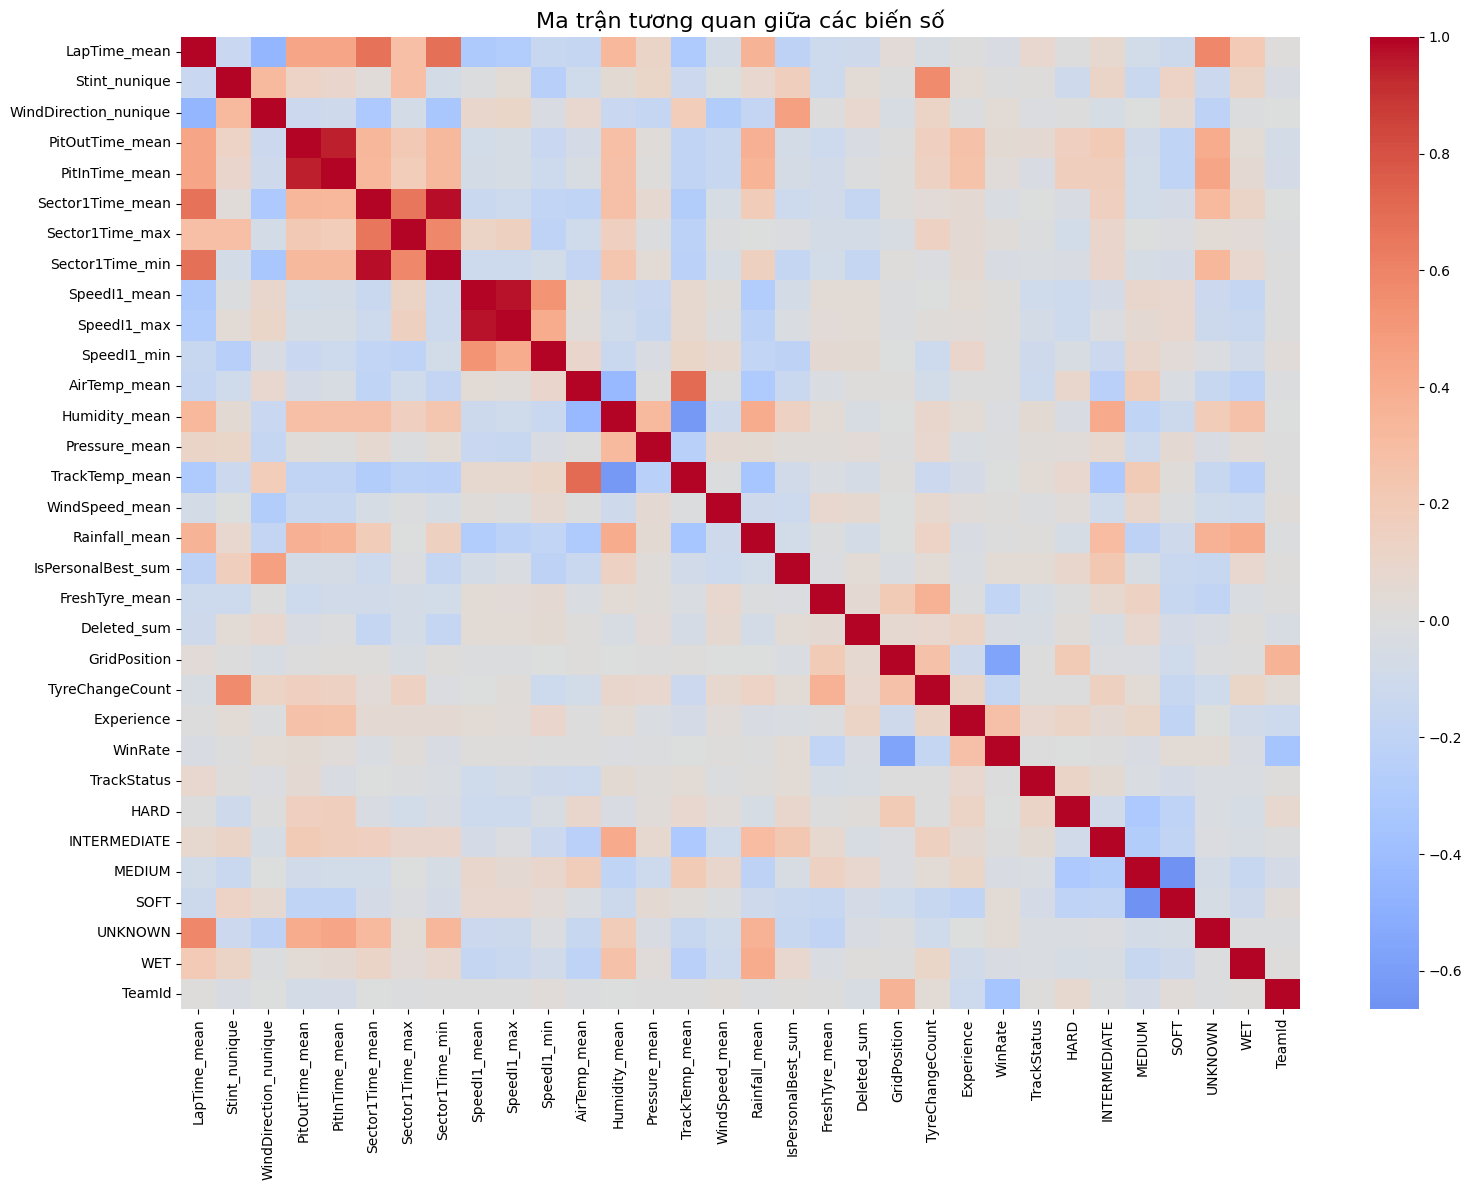

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo dataframe từ correlation matrix
corr_df = pd.DataFrame(correlation_matrix, columns=numeric_cols, index=numeric_cols)

# Cấu hình kích thước hiển thị phù hợp
plt.figure(figsize=(16, 12))

# Vẽ heatmap
sns.heatmap(corr_df, cmap="coolwarm", annot=False, fmt=".2f", center=0)

# Tiêu đề
plt.title("Ma trận tương quan giữa các biến số", fontsize=16)

# Hiển thị
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

correlations = []

for col_name in numeric_cols:
    # Bỏ qua PositionGroup
    if col_name == "PositionGroup":
        continue

    # Tạo vector với cột hiện tại và PositionGroup
    assembler = VectorAssembler(inputCols=[col_name, "PositionGroup"], outputCol="vec")
    df_vec = assembler.transform(spark_df.select(col_name, "PositionGroup")).select("vec")

    # Tính ma trận tương quan
    corr_matrix = Correlation.corr(df_vec, "vec", "pearson").head()[0].toArray()

    # Lấy hệ số tương quan giữa col_name và PositionGroup (luôn nằm ở [0,1] hoặc [1,0])
    corr = corr_matrix[0, 1]
    correlations.append((col_name, corr))

# Chuyển sang Pandas để dễ xem
import pandas as pd

correlation_df = pd.DataFrame(correlations, columns=["Feature", "CorrelationWithPositionGroup"])
correlation_df["AbsCorr"] = correlation_df["CorrelationWithPositionGroup"].abs()

# Sắp xếp theo độ tương quan tuyệt đối
correlation_df_sorted = correlation_df.sort_values(by="AbsCorr", ascending=False)

print(correlation_df_sorted.head(32))

                  Feature  CorrelationWithPositionGroup   AbsCorr
20           GridPosition                      0.581961  0.581961
23                WinRate                     -0.529464  0.529464
31                 TeamId                      0.330069  0.330069
2   WindDirection_nunique                     -0.291285  0.291285
17     IsPersonalBest_sum                     -0.249527  0.249527
21        TyreChangeCount                      0.144457  0.144457
18         FreshTyre_mean                      0.127566  0.127566
22             Experience                     -0.113956  0.113956
1           Stint_nunique                     -0.101891  0.101891
0            LapTime_mean                      0.079548  0.079548
3         PitOutTime_mean                     -0.068020  0.068020
25                   HARD                      0.066605  0.066605
10            SpeedI1_min                      0.058927  0.058927
28                   SOFT                     -0.053582  0.053582
7         

In [ ]:
# Tạo bản sao của DataFrame
spark_dff = spark_df.select("*")

In [ ]:
spark_df = drop_columns(spark_df, ["PitInTime_mean", "Sector1Time_min", "SpeedI1_max"])  # nếu còn

##### __TRAIN MODEL__

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Biến đầu vào
feature_cols = [col for col in spark_df.columns if col not in ['PositionGroup']]
label_indexer = StringIndexer(inputCol="PositionGroup", outputCol="label")
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

pipeline = Pipeline(stages=[label_indexer, assembler, rf])

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

rf_model = cv.fit(spark_df)

# Dự đoán trên dữ liệu
predictions = rf_model.transform(spark_df)
print("Random Forest Accuracy:", evaluator.evaluate(rf_model.transform(spark_df)))

# Tính toán accuracy
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

# Tính toán precision
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
print("Precision:", precision)

# Tính toán recall
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
print("Recall:", recall)

# Ma trận nhầm lẫn
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)

# In ma trận nhầm lẫn
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)

# Các metric khác như True Positive Rate, False Positive Rate, v.v.
labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in labels:
    print(f"Class {label}:")
    print(f"  Precision: {metrics.precision(label)}")
    print(f"  Recall: {metrics.recall(label)}")

Random Forest Accuracy: 0.6407158836689038
Accuracy: 0.6407158836689038
Precision: 0.6532718507644978
Recall: 0.6407158836689039


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[448.  95.  15.   2.]
 [ 96. 297. 155.  12.]
 [ 27. 105. 356.  72.]
 [ 31.  44. 149. 331.]]
Class 0.0:
  Precision: 0.7441860465116279
  Recall: 0.8
Class 1.0:
  Precision: 0.5489833641404805
  Recall: 0.5303571428571429
Class 3.0:
  Precision: 0.7937649880095923
  Recall: 0.5963963963963964
Class 2.0:
  Precision: 0.5274074074074074
  Recall: 0.6357142857142857


In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=20, featuresCol="features", labelCol="label")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()

pipeline = Pipeline(stages=[label_indexer, assembler, lr])

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

lr_model = cv.fit(spark_df)
print("Logistic Regression Accuracy:", evaluator.evaluate(lr_model.transform(spark_df)))

# Dự đoán trên dữ liệu
predictions = lr_model.transform(spark_df)
print("Random Forest Accuracy:", evaluator.evaluate(lr_model.transform(spark_df)))

# Tính toán accuracy
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

# Tính toán precision
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
print("Precision:", precision)

# Tính toán recall
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
print("Recall:", recall)

# Ma trận nhầm lẫn
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)

# In ma trận nhầm lẫn
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)

# Các metric khác như True Positive Rate, False Positive Rate, v.v.
labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in labels:
    print(f"Class {label}:")
    print(f"  Precision: {metrics.precision(label)}")
    print(f"  Recall: {metrics.recall(label)}")

Logistic Regression Accuracy: 0.5812080536912752
Random Forest Accuracy: 0.5812080536912752
Accuracy: 0.5812080536912752
Precision: 0.5755907784289198
Recall: 0.5812080536912752
Confusion Matrix:
[[437.  98.  15.  10.]
 [144. 240. 114.  62.]
 [ 38.  99. 297. 126.]
 [ 44.  41. 145. 325.]]
Class 0.0:
  Precision: 0.6591251885369532
  Recall: 0.7803571428571429
Class 1.0:
  Precision: 0.502092050209205
  Recall: 0.42857142857142855
Class 3.0:
  Precision: 0.621414913957935
  Recall: 0.5855855855855856
Class 2.0:
  Precision: 0.5201401050788091
  Recall: 0.5303571428571429


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .build()

pipeline = Pipeline(stages=[label_indexer, assembler, dt])

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

dt_model = cv.fit(spark_df)
print("Decision Tree Accuracy:", evaluator.evaluate(dt_model.transform(spark_df)))

# Dự đoán trên dữ liệu
predictions = dt_model.transform(spark_df)
print("Random Forest Accuracy:", evaluator.evaluate(dt_model.transform(spark_df)))

# Tính toán accuracy
accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

# Tính toán precision
precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
print("Precision:", precision)

# Tính toán recall
recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
print("Recall:", recall)

# Ma trận nhầm lẫn
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)

# In ma trận nhầm lẫn
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)

# Các metric khác như True Positive Rate, False Positive Rate, v.v.
labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in labels:
    print(f"Class {label}:")
    print(f"  Precision: {metrics.precision(label)}")
    print(f"  Recall: {metrics.recall(label)}")

Decision Tree Accuracy: 0.6246085011185681
Random Forest Accuracy: 0.6246085011185681
Accuracy: 0.6246085011185682
Precision: 0.6400551456326297
Recall: 0.6246085011185681
Confusion Matrix:
[[433.  99.  26.   2.]
 [101. 305. 141.  13.]
 [ 24. 123. 341.  72.]
 [ 30.  51. 157. 317.]]
Class 0.0:
  Precision: 0.7363945578231292
  Recall: 0.7732142857142857
Class 1.0:
  Precision: 0.527681660899654
  Recall: 0.5446428571428571
Class 3.0:
  Precision: 0.7846534653465347
  Recall: 0.5711711711711712
Class 2.0:
  Precision: 0.512781954887218
  Recall: 0.6089285714285714


In [ ]:
# Lưu mô hình
rf_model.write().overwrite().save("models/rf_model")
lr_model.write().overwrite().save("models/lr_model")
dt_model.write().overwrite().save("models/dt_model")

In [ ]:
from pyspark.ml.tuning import CrossValidatorModel

# Đọc mô hình đã lưu
rf_model = CrossValidatorModel.load("models/rf_model")
lr_model = CrossValidatorModel.load("models/lr_model")
dt_model = CrossValidatorModel.load("models/dt_model")

# In ra các tham số tốt nhất của từng mô hình
print("=== Random Forest Best Params ===")
print(rf_model.bestModel.stages[-1].extractParamMap())

print("\n=== Logistic Regression Best Params ===")
print(lr_model.bestModel.stages[-1].extractParamMap())

print("\n=== Decision Tree Best Params ===")
print(dt_model.bestModel.stages[-1].extractParamMap())

=== Random Forest Best Params ===
{Param(parent='RandomForestClassifier_668953d6471f', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_668953d6471f', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestClassifier_668953d6471f', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestClassifier_668953d6471f', name='featureSubsetStrategy', doc="The number of features to consider for

In [ ]:
import pandas as pd

def extract_param_map(param_map):
    return {param.name: value for param, value in param_map.items()}

# Get best models from CrossValidatorModels
rf_best_model = rf_model.bestModel
lr_best_model = lr_model.bestModel
dt_best_model = dt_model.bestModel

# Get best param maps
rf_params = extract_param_map(rf_best_model.stages[-1].extractParamMap())
lr_params = extract_param_map(lr_best_model.stages[-1].extractParamMap())
dt_params = extract_param_map(dt_best_model.stages[-1].extractParamMap())

# Convert to DataFrame
df_params = pd.DataFrame({
    "Random Forest": pd.Series(rf_params),
    "Logistic Regression": pd.Series(lr_params),
    "Decision Tree": pd.Series(dt_params),
})

# Print the table
df_params

,Random Forest,Logistic Regression,Decision Tree
aggregationDepth,NaN,2,NaN
bootstrap,True,NaN,NaN
cacheNodeIds,False,NaN,False
checkpointInterval,10,NaN,10
elasticNetParam,NaN,0.5,NaN
family,NaN,auto,NaN
featureSubsetStrategy,auto,NaN,NaN
featuresCol,features,features,features
fitIntercept,NaN,True,NaN
impurity,gini,NaN,gini


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_params)

https://docs.google.com/spreadsheets/d/1pIBRNfXDHFluO2ReugpdoaYwZ9YNKFrThHkFPH4uEDM/edit#gid=0


##### __DEV DATA__

In [ ]:
dev_data = preprocess_fastf1_data(
    base_folder_path='/content/drive/My Drive/Fastf1/raw/',
    years=['TEST'],
    spark=spark,
    schema_laps=schema_laps,
    schema_weather=schema_weather,
    count_tyre_life_1=count_tyre_life_1,
    driver_stats={}
)

In [ ]:
dev_data = add_position_group(dev_data, drop_position=True)

In [ ]:
columns_to_drop = ['Wins', 'ClassifiedPosition', 'Points']
# numeric_cols = ['LapTime_mean', 'PitOutTime_mean', 'PitInTime_mean', 'Sector1Time_mean', 'Sector1Time_max', 'Sector1Time_min', 'SpeedI1_mean', 'SpeedI1_max', 'SpeedI1_min']

dev_data = drop_columns(dev_data, columns_to_drop)
dev_data = add_position_group(dev_data, drop_position=True)
dev_data = fill_numeric_with_mean(dev_data, numeric_cols)
dev_data = convert_track_status(dev_data)
dev_data = cast_columns_to_int(dev_data, ["DriverNumber", "IsPersonalBest_sum"])
dev_data = dev_data.fillna({'TyreChangeCount': 0})
dev_data = one_hot_encode_compound_mode(dev_data)
dev_data = label_encode_column(dev_data, "TeamId")
dev_data = convert_booleans_to_int(dev_data)
dev_data = dev_data.fillna({"TrackStatus": 0})
dev_data = drop_columns(dev_data, ["DriverNumber"])  # nếu còn

print("✅ Số hàng:", dev_data.count(), " | Số cột:", len(dev_data.columns))
dev_data.printSchema()

In [ ]:
dev_data = drop_columns(dev_data, ["PitInTime_mean", "Sector1Time_min", "SpeedI1_max"])  # nếu còn

In [ ]:
from pyspark.sql.functions import lit

def align_test_to_train(test_df, train_df):
    """
    Chuẩn hóa test_df sao cho có cấu trúc giống train_df:
    - Xóa cột thừa
    - Thêm cột thiếu (giá trị mặc định là 0)
    - Sắp xếp thứ tự cột giống train_df
    """
    train_columns = train_df.columns
    test_columns = test_df.columns

    # 1. Xóa các cột không có trong train_df
    columns_to_drop = [col for col in test_columns if col not in train_columns]
    test_df = test_df.drop(*columns_to_drop)

    # 2. Thêm các cột còn thiếu và điền 0
    missing_columns = [col for col in train_columns if col not in test_df.columns]
    for col in missing_columns:
        test_df = test_df.withColumn(col, lit(0))

    # 3. Đảm bảo đúng thứ tự cột
    test_df = test_df.select(train_columns)

    return test_df

In [ ]:
dev_data = align_test_to_train(dev_data, spark_df)

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.sql.functions import udf
from pyspark.ml.tuning import CrossValidatorModel

# Định nghĩa hàm dự đoán cho mô hình
def predict_with_model(model_path, test_data, label_col="PositionGroup"):
    # Tải mô hình đã huấn luyện
    model = CrossValidatorModel.load(model_path)
    model = model.bestModel

    if 'label_init' in test_data.columns:
        test_data = test_data.drop('label_init')

    # Tạo pipeline cho dữ liệu test
    indexer = StringIndexer(inputCol=label_col, outputCol="label_init2")
    indexer_model = indexer.fit(test_data)
    label_mapping = indexer_model.labels

    # Áp dụng pipeline cho dữ liệu test
    preprocessed_test_df = indexer_model.transform(test_data)

    # Dự đoán với mô hình đã huấn luyện
    predictions = model.transform(preprocessed_test_df)

    # Bước 5: Hàm UDF giải mã nhãn
    def decode_label(index):
        try:
            return label_mapping[int(index)]
        except:
            return None

    decode_udf = udf(decode_label, StringType())

    # Bước 6: Thêm cột nhãn gốc cho label và prediction
    predictions = predictions \
        .withColumn("true_label", decode_udf("label_init2")) \
        .withColumn("predicted_label", decode_udf("prediction"))

    return predictions.select("PositionGroup", "true_label", "predicted_label", "label_init2", "prediction")

# Dự đoán với các mô hình khác nhau
predictions_dt = predict_with_model('/content/models/dt_model', dev_data)
predictions_rf = predict_with_model('/content/models/rf_model', dev_data)
predictions_lr = predict_with_model('/content/models/lr_model', dev_data)

# Hiển thị kết quả cho từng mô hình
print("Decision Tree Predictions:")
predictions_dt.show()

print("Random Forest Predictions:")
predictions_rf.show()

print("Logistic Regression Predictions:")
predictions_lr.show()

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import DataFrame

def calculate_label_accuracy(predictions: DataFrame, label_col='label_init2', prediction_col='prediction', show_result=True):
    """
    Tính độ chính xác cho từng nhãn trong DataFrame dự đoán từ mô hình Spark ML.

    Args:
        predictions (DataFrame): DataFrame chứa các cột `label` và `prediction`
        label_col (str): Tên cột nhãn thật
        prediction_col (str): Tên cột nhãn dự đoán
        show_result (bool): Có in ra bảng kết quả không

    Returns:
        dict: Từ điển chứa độ chính xác theo nhãn
    """
    # Nhóm theo nhãn thật và nhãn dự đoán
    grouped = predictions.groupBy(label_col, prediction_col).count().collect()

    accuracy_stats = {}

    for row in grouped:
        true_label = row[label_col]
        pred_label = row[prediction_col]
        count = row['count']

        if true_label not in accuracy_stats:
            accuracy_stats[true_label] = {'correct': 0, 'total': 0}

        if true_label == pred_label:
            accuracy_stats[true_label]['correct'] += count

        accuracy_stats[true_label]['total'] += count

    # Tính độ chính xác theo từng nhãn
    label_accuracy = {
        label: round((stat['correct'] / stat['total']) * 100, 2)
        for label, stat in accuracy_stats.items()
    }

    if show_result:
        print("\n🎯 Label-wise Accuracy:")
        for label, acc in sorted(label_accuracy.items()):
            print(f" - Label {label}: {acc:.2f}%")

    return label_accuracy

# Tính độ chính xác cho từng nhãn
label_accuracy_dt = calculate_label_accuracy(predictions_dt)
label_accuracy_rf = calculate_label_accuracy(predictions_rf)
label_accuracy_lr = calculate_label_accuracy(predictions_lr)

# Hiển thị độ chính xác cho từng nhãn
print("Decision Tree Label Accuracy:")
print(label_accuracy_dt)

print("Random Forest Label Accuracy:")
print(label_accuracy_rf)

print("Logistic Regression Label Accuracy:")
print(label_accuracy_lr)